MODELLER is used for homology or comparative modeling of protein three-dimensional structures (1,2). The user provides an alignment of a sequence to be modeled with known related structures and MODELLER automatically calculates a model containing all non-hydrogen atoms. MODELLER implements comparative protein structure modeling by satisfaction of spatial restraints (3,4), and can perform many additional tasks, including de novo modeling of loops in protein structures, optimization of various models of protein structure with respect to a flexibly defined objective function, multiple alignment of protein sequences and/or structures, clustering, searching of sequence databases, comparison of protein structures, etc. MODELLER is available for download for most Unix/Linux systems, Windows, and Mac.

In [138]:
!wget https://salilab.org/modeller/9v4/tutorial/basic-example.tar.gz
!tar -xzf basic-example.tar.gz 

--2021-04-12 10:21:36--  https://salilab.org/modeller/tutorial/advanced-example.tar.gz
Resolving salilab.org (salilab.org)... 169.230.79.19
Connecting to salilab.org (salilab.org)|169.230.79.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3945077 (3.8M) [application/x-gzip]
Saving to: ‘advanced-example.tar.gz.1’

advanced-example.ta 100%[===================>]   3.76M  2.11MB/s    in 1.8s    

2021-04-12 10:21:39 (2.11 MB/s) - ‘advanced-example.tar.gz.1’ saved [3945077/3945077]

tar (child): advanced-example-example.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


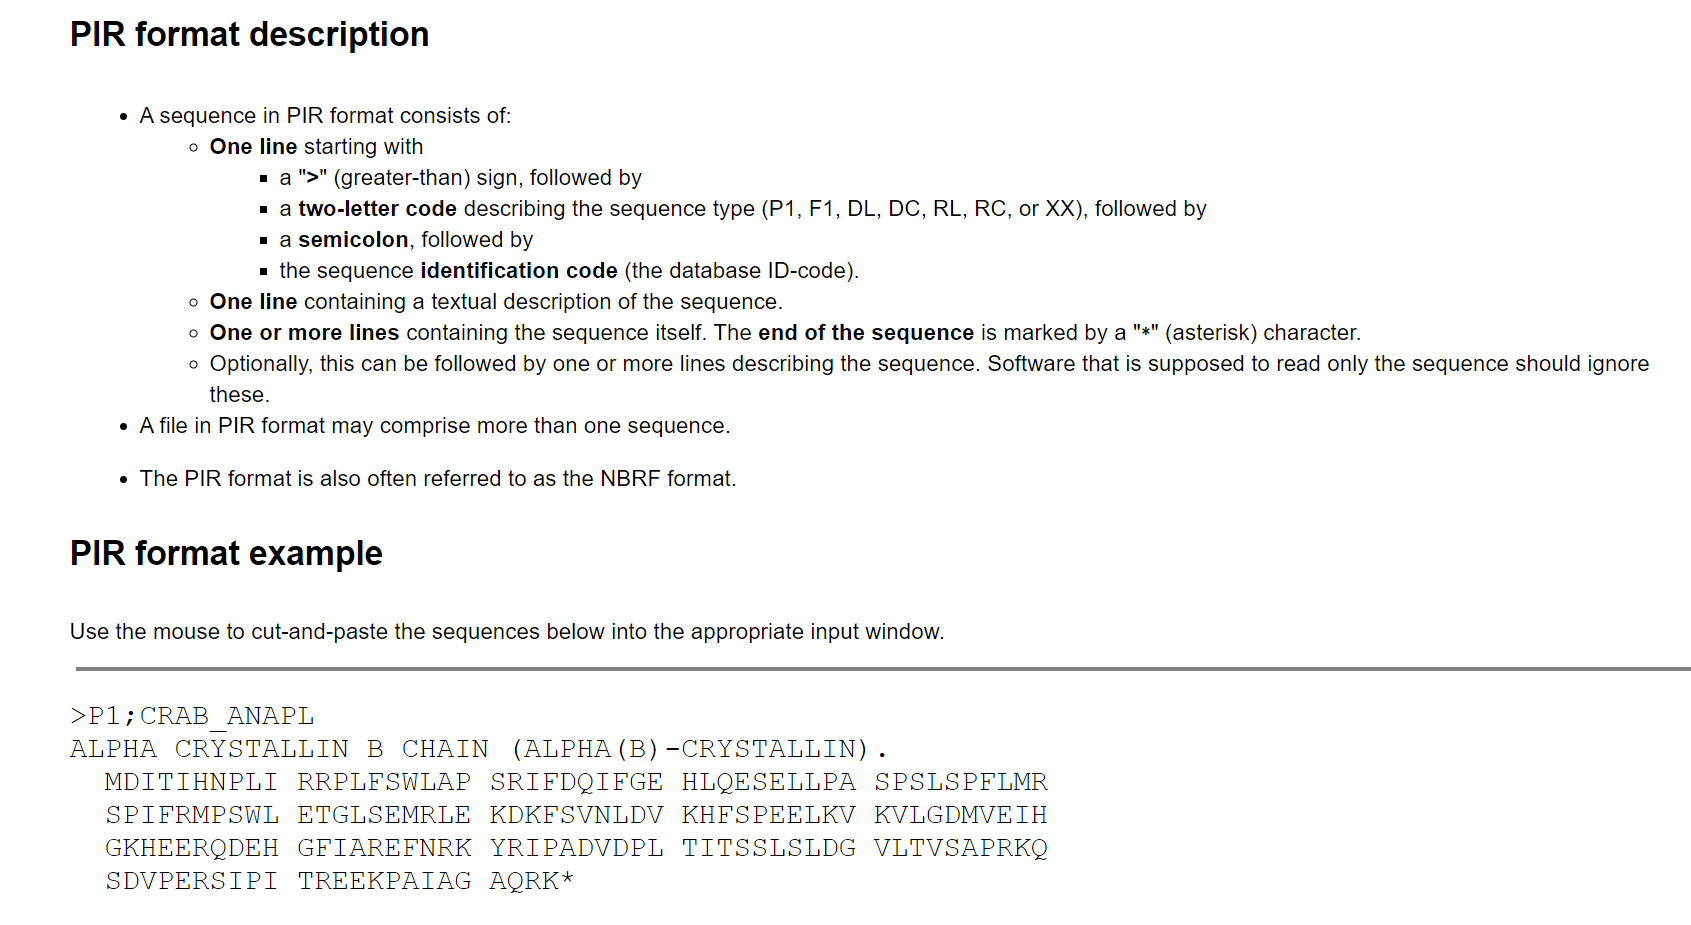
                          'P1'  protein, complete
                          'F1'  protein, fragment

In [56]:
from modeller import *
from modeller.automodel import * 
from Bio import pairwise2
from Bio.SeqUtils import seq1
import MDAnalysis as mda
import nglview as nv

_ColormakerRegistry()

In [1]:
from modeller import *

# Basic tutorial

# 1. Searching for structures related to TvLDH

1. Initializes the 'environment' for this modeling run, by creating a new 'environ' object. Almost all MODELLER scripts require this step, as the new object (which we call here 'env', but you can call it anything you like) is needed to build most other useful objects.
2. Creates a new 'sequence_db' object, calling it 'sdb'. 'sequence_db' objects are used to contain large databases of protein sequences.

In [35]:
from modeller import *

log.verbose()
env = environ()

#-- Read in the sequence database (последовательности без gap)
sdb = sequence_db(env)

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      1174513    1146.985     1.120

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      1175041    1147.501     1.121
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      1223641    1194.962     1.167
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      1236941    1207.950     1.180
openf___224_> Open           $

3. Reads a text format file containing non-redundant PDB sequences at 95% sequence identity into the sdb database. The sequences can be found in the file "pdb_95.pir" (which can be downloaded using the link at the top of this page). Like the previously-created alignment, this file is in PIR format. Sequences which have fewer than 30 or more than 4000 residues are discarded, and non-standard residues are removed.

In [36]:
sdb.read(seq_database_file='pdb_95.pir', seq_database_format='PIR',
         chains_list='ALL', minmax_db_seq_len=(30, 4000), clean_sequences=True)

openf___224_> Open           pdb_95.pir

Dynamically allocated memory at amaxsequence_db [B,KiB,MiB]:      1237023    1208.030     1.180

Dynamically allocated memory at amaxsequence_db [B,KiB,MiB]:      1824157    1781.403     1.740

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:      1825999    1783.202     1.741

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:      1827449    1784.618     1.743

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:      1830349    1787.450     1.746

Dynamically allocated memory at amaxsequence_db [B,KiB,MiB]:      4046148    3951.316     3.859

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:      4051948    3956.980     3.864

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:      4063548    3968.309     3.875

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:      4086748    3990.965     3.897

Dynamically allocated memory at amaxsequence_db [B,KiB,MiB]:      5194648    5072.898 

4. Writes a binary machine-specific file containing all sequences read in the previous step.

In [22]:
#-- Write the sequence database in binary form
sdb.write(seq_database_file='pdb_95.bin', seq_database_format='BINARY',
          chains_list='ALL')


SEQ_DATABASE_FILE         : pdb_95.bin
SEQ_DATABASE_FORMAT       : BINARY
SEARCH_CHAINS_LIST        : ALL
Number of sequences       :        11079
Number of residues        :      2436254
Length of longest sequence:         1491



5. Reads the binary format file back in. Note that if you plan to use the same database several times, you should use the previous two steps only the first time, to produce the binary database. On subsequent runs, you can omit those two steps and use the binary file directly, since reading the binary file is a lot faster than reading the PIR file.

In [23]:
#-- Now, read in the binary database
sdb.read(seq_database_file='pdb_95.bin', seq_database_format='BINARY',
         chains_list='ALL')



SEQ_DATABASE_FILE         : pdb_95.bin
SEQ_DATABASE_FORMAT       : BINARY
CHAINS_LIST               : ALL
CLEAN_SEQUENCES           :            T
MINMAX_DB_SEQ_LEN         :            0      999999
Number of sequences       :        11079
Number of residues        :      2436254
Length of longest sequence:         1491



6. Creates a new 'alignment' object, calling it 'aln', reads our query sequence "TvLDH" from the file "TvLDH.ali", and converts it to a profile 'prf'. Profiles contain similar information to alignments, but are more compact and better for sequence database searching.

In [24]:
#-- Read in the target sequence/alignment
aln = alignment(env)
aln.append(file='TvLDH.ali', alignment_format='PIR', align_codes='ALL')

openf___224_> Open           TvLDH.ali

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:       554890     541.885     0.529

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:       556340     543.301     0.531

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:       559240     546.133     0.533

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:       565040     551.797     0.539

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       566376     553.102     0.540

Read the alignment from file       : TvLDH.ali
Total number of alignment positions:   335

  #  Code        #_Res #_Segm PDB_code    Name
-------------------------------------------------------------------------------
  1      TvLDH     335      1       TvLDH


1

In [25]:
aln

Alignment of Sequence 'TvLDH'

In [26]:
#-- Convert the input sequence/alignment into
#   profile format
prf = aln.to_profile()


Dynamically allocated memory at     amaxprofile [B,KiB,MiB]:       568041     554.728     0.542


7. Searches the sequence database 'sdb' for our query profile 'prf'. Matches from the sequence database are added to the profile.

In [29]:
#-- Scan sequence database to pick up homologous sequences
prf.build(sdb, matrix_offset=-450, rr_file='${LIB}/blosum62.sim.mat',
          gap_penalties_1d=(-500, -50), n_prof_iterations=1,
          check_profile=False, max_aln_evalue=0.01)

openf___224_> Open           ${LIB}/blosum62.sim.mat
rdrrwgh_268_> Number of residue types:       21

Dynamically allocated memory at amaxsequence_db [B,KiB,MiB]:       844511     824.718     0.805
profile_iteration_> processing sequence:       1    335      1     0.0200000     0.0200000     0.0200000     1

Dynamically allocated memory at amaxsequence_db [B,KiB,MiB]:       853808     833.797     0.814
profile_iteration_> processing sequence:    1109    335      1     1.0100000     0.0009107     0.0000042  1098

Dynamically allocated memory at amaxsequence_db [B,KiB,MiB]:       861596     841.402     0.822
profile_iteration_> processing sequence:    2217    335      1     2.0599999     0.0009292     0.0000042  1076
profile_iteration_> processing sequence:    3325    335      1     2.9900000     0.0008992     0.0000040  1112
profile_iteration_> processing sequence:    4433    335      1     3.9000001     0.0008798     0.0000039  1137
profile_iteration_> processing sequence:    5541    3

8. Writes a profile of the query sequence and its homologs (see file "build_profile.prf"). The equivalent information is also written out in standard alignment format.

In [30]:
#-- Write out the profile in text format
prf.write(file='build_profile.prf', profile_format='TEXT')

openf___224_> Open           build_profile.prf


In [31]:
#-- Convert the profile back to alignment format
aln = prf.to_alignment()


Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:       955847     933.444     0.912

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       957183     934.749     0.913

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       957835     935.386     0.913

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       959095     936.616     0.915

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       960327     937.819     0.916

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       961275     938.745     0.917

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       962571     940.011     0.918

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       963723     941.136     0.919

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       964831     942.218     0.920

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:       965459     942.831     0.921

Dynamically allocated memory 

In [32]:
#-- Write out the alignment file
aln.write(file='build_profile.ali', alignment_format='PIR')

openf___224_> Open           build_profile.ali


The SequenceDB class holds a database of sequences. Such a database is similar to a multiple sequence alignment, but contains less auxiliary information (for example, no sequence may contain gaps). This requires less memory than a true alignment, and is thus more suited for large databases of sequences. Such a database can be scanned for matches to an input sequence with SequenceDB.search(), used to build sequence profiles with Profile.build() or filtered by given criteria with SequenceDB.filter().

# 2. Selecting a template

The most important columns in the profile.build() output are the second, tenth, eleventh and twelfth columns. The second column reports the code of the PDB sequence that was compared with the target sequence. The PDB code in each line is the representative of a group of PDB sequences that share 95% or more sequence identity to each other and have less than 30 residues or 30% sequence length difference. The eleventh column reports the percentage sequence identities between TvLDH and a PDB sequence normalized by the lengths of the alignment (indicated in the tenth column). In general, a sequence identity value above approximately 25% indicates a potential template unless the alignment is short (i.e., less than 100 residues). A better measure of the significance of the alignment is given in the twelfth column by the e-value of the alignment. In this example, six PDB sequences show very significant similarities to the query sequence with e-values equal to 0. As expected, all the hits correspond to malate dehydrogenases (1bdm:A, 5mdh:A, 1b8p:A, 1civ:A, 7mdh:A, and 1smk:A). To select the most appropriate template for our query sequence over the six similar structures, we will use the alignment.compare_structures() command to assess the structural and sequence similarity between the possible templates (file "compare.py").

In [48]:
env = environ()
aln = alignment(env)

for (pdb, chain) in (('1b8p', 'A'), ('1bdm', 'A'), ('1civ', 'A'),
                     ('5mdh', 'A'), ('7mdh', 'A'), ('1smk', 'A')):
    m = model(env, file=pdb, model_segment=('FIRST:'+chain, 'LAST:'+chain))
    aln.append_model(m, atom_files=pdb, align_codes=pdb+chain)
aln.malign()
aln.malign3d()
aln.compare_structures()
aln.id_table(matrix_file='family.mat')

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      9720054    9492.240     9.270

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      9720582    9492.756     9.270
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      9769182    9540.217     9.317
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      9782482    9553.205     9.329
openf___224_> Open           $

In [49]:
env.dendrogram(matrix_file='family.mat', cluster_cut=-1.0)

openf___224_> Open           family.mat


Weighted pair-group average clustering based on a distance matrix:



Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:      9529810    9306.455     9.088
                                           .----------------------- 1b8pA @1.9    39.0000
                                           |
                                  .-------------------------------- 1bdmA @1.8    50.5000
                                  |
                              .------------------------------------ 5mdhA @2.4    55.3750
                              |
                              |                                .--- 1civA @2.8    13.0000
                              |                                |
        .---------------------------------------------------------- 7mdhA @2.4    83.2500
        |
      .------------------------------------------------------------ 1smkA @2.5

      +----+----+----+----+----+----+----+----+----+----+----+----+
    86

File: compare.py

In this case, we create an (initially empty) alignment object 'aln' and then use a Python 'for' loop to instruct MODELLER to read each of the PDB files. (Note that in order for this to work, you must have all of the PDB files in the same directory as this script, either downloaded from the PDB website or from the archive linked at the top of this page.) We use the model_segment argument to ask only for a single chain to be read from each PDB file (by default, all chains are read from the file). As each structure is read in, we use the append_model method to add the structure to the alignment.

At the end of the loop, all of the structures are in the alignment, but they are not ideally aligned to each other (append_model creates a simple 1:1 alignment with no gaps). Therefore, we improve this alignment by using malign to calculate a multiple sequence alignment. **The malign3d command then performs an iterative least-squares superposition of the six 3D structures, using the multiple sequence alignment as its starting point. The compare_structures command compares the structures according to the alignment constructed by malign3d.** It does not make an alignment, but **it calculates the RMS and DRMS deviations between atomic positions and distances, differences between the mainchain and sidechain dihedral angles, percentage sequence identities, and several other measures.** Finally, the id_table command writes a file with pairwise sequence distances that can be used directly as the input to the dendrogram command (or the clustering programs in the PHYLIP package). dendrogram calculates a clustering tree from the input matrix of pairwise distances, which helps visualizing differences among the template candidates. Excerpts from the log file are shown below (file "compare.log").

The comparison above shows that 1civ:A and 7mdh:A are almost identical, both sequentially and structurally. However, 7mdh:A has a better crystallographic resolution (2.4Å versus 2.8Å), eliminating 1civ:A. A second group of structures (5mdh:A, 1bdm:A, and 1b8p:A) share some similarities. From this group, 5mdh:A has the poorest resolution leaving for consideration only 1bdm:A and 1b8p:A. 1smk:A is the most diverse structure of the whole set of possible templates. However, it is the one with the lowest sequence identity (34%) to the query sequence. **We finally pick 1bdm:A** over 1b8p:A and 7mdh:A because of its better crystallographic R-factor (16.9%) and higher overall sequence identity to the query sequence (45%).

In [72]:
import MDAnalysis



In [77]:
u=MDAnalysis.Universe('1smk.pdb')
s=u.select_atoms('segid A')

view=nv.show_mdanalysis(s)
view

NGLWidget()

In [76]:
#view.clear()
#view.add_cartoon('protein or nucleic',color='pink')
view

NGLWidget()

# 3. Aligning TvLDF with the template

A good way of aligning the sequence of TvLDH with the structure of 1bdm:A is the align2d() command in MODELLER. Although align2d() is based on a dynamic programming algorithm, it is different from standard sequence-sequence alignment methods because it takes into account structural information from the template when constructing an alignment. **This task is achieved through a variable gap penalty function that tends to place gaps in solvent exposed and curved regions, outside secondary structure segments, and between two positions that are close in space. As a result, the alignment errors are reduced by approximately one third relative to those that occur with standard sequence alignment techniques.** This improvement becomes more important as the similarity between the sequences decreases and the number of gaps increases. In the current example, the template-target similarity is so high that almost any alignment method with reasonable parameters will result in the same alignment. The following MODELLER script aligns the TvLDH sequence in file "TvLDH.ali" with the 1bdm:A structure in the PDB file "1bdm.pdb" (file "align2d.py").

In this script, we again create an 'environ' object to use as input to later commands. We create an empty alignment 'aln', and then a new protein model 'mdl', into which we read the chain A segment of the 1bdm PDB structure file. The append_model() command transfers the PDB sequence of this model to the alignment and assigns it the name of "1bdmA" (align_codes). Then we add the "TvLDH" sequence from file "TvLDH.seq" to the alignment, using the append() command. The align2d() command is then executed to align the two sequences. Finally, the alignment is written out in two formats, PIR ("TvLDH-1bdmA.ali") and PAP ("TvLDH-1bdmA.pap"). The PIR format is used by MODELLER in the subsequent model building stage, while the PAP alignment format is easier to inspect visually. Due to the high target-template similarity, there are only a few gaps in the alignment. In the PAP format, all identical positions are marked with a "*" (file "TvLDH-1bdmA.pap").

In [50]:
aln = alignment(env)
mdl = model(env, file='1bdm', model_segment=('FIRST:A','LAST:A'))
aln.append_model(mdl, align_codes='1bdmA', atom_files='1bdm.pdb')
aln.append(file='TvLDH.ali', align_codes='TvLDH')
aln.align2d()
aln.write(file='TvLDH-1bdmA.ali', alignment_format='PIR')
aln.write(file='TvLDH-1bdmA.pap', alignment_format='PAP')

openf___224_> Open           1bdm.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      8200122    8007.932     7.820

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      8200198    8008.006     7.820

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      8200369    8008.173     7.820

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      8201219    8009.003     7.821

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      8202477    8010.231     7.822

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      8204381    8012.091     7.824

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      8204421    8012.130     7.824

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      8204511    8012.218     7.824

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      8207367    8015.007     7.827

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      8207427    8015.065   

# 4. Model building

The first line loads in the automodel class and prepares it for use. We then create an automodel object, call it 'a', and set parameters to guide the model building procedure. alnfile names the file that contains the target-template alignment in the PIR format. knowns defines the known template structure(s) in alnfile ("TvLDH-1bdmA.ali"). sequence defines the name of the target sequence in alnfile. assess_methods requests one or more assessment scores (discussed in more detail in the next section). starting_model and ending_model define the number of models that are calculated (their indices will run from 1 to 5). The last line in the file calls the make method that actually calculates the models.

The most important output file is "model-single.log", which reports warnings, errors and other useful information including the input restraints used for modeling that remain violated in the final model. The last few lines from this log file are shown below.

-  **an   atomic   distance-dependent   statistical potential  from  known  native  protein  structures  (DOPE),based  on   probability  theory  and   without  recourse   to statistical mechanic**
- the DOPE (Discrete Optimized Protein Energy) method. This is a statistical potential optimized for model assessment. As with model.assess_ga341(), this should be used for single chains only.


In [54]:
from modeller.automodel import *

env = environ()
a = automodel(env, alnfile='TvLDH-1bdmA.ali',
              knowns='1bdmA', sequence='TvLDH',
              assess_methods=(assess.DOPE,
                              #soap_protein_od.Scorer(),
                              assess.GA341))
a.starting_model = 1
a.ending_model = 5
a.make()

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     27936020   27281.270    26.642

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     27936548   27281.785    26.642
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     27985148   27329.246    26.689
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     27998448   27342.234    26.701
openf___224_> Open           $

In [78]:
u=MDAnalysis.Universe('TvLDH.B99990005.pdb')
#s=u.select_atoms('segid A')

view=nv.show_mdanalysis(s)
view

NGLWidget()

In [83]:
%%time

from modeller import *
from modeller.scripts import complete_pdb

log.verbose()    # request verbose output
env = environ()
env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters

# read model file
mdl = complete_pdb(env, 'TvLDH.B99990002.pdb')

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='TvLDH.profile',
              normalize_profile=True, smoothing_window=15)

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35715226   34878.148    34.061

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35715754   34878.664    34.061
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35764354   34926.125    34.108
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35777654   34939.117    34.120
openf___224_> Open           $

-37645.75

In [80]:
view=nv.show_structure_file('TvLDH.B99990002.pdb')
view.add_structure(nv.FileStructure('1bdm.pdb'))
view

NGLWidget()

In [85]:
import pylab
import modeller

def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals


openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35715226   34878.148    34.061

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35715754   34878.664    34.061
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35764354   34926.125    34.108
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     35777654   34939.117    34.120
openf___224_> Open           $

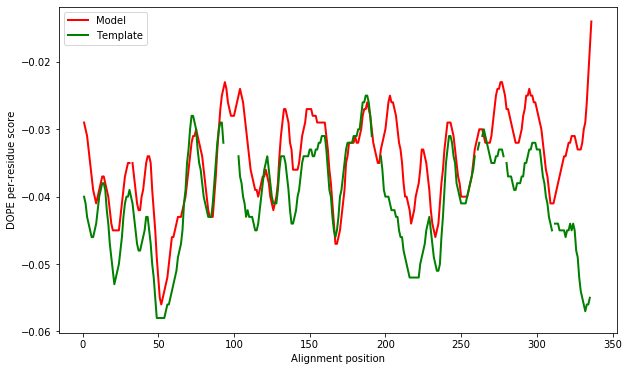

In [86]:
e = modeller.environ()
a = modeller.alignment(e, file='TvLDH-1bdmA.ali')

template = get_profile('1bdmA.profile', a['1bdmA'])
model = get_profile('TvLDH.profile', a['TvLDH'])

# Plot the template and model profiles in the same plot for comparison:
pylab.figure(1, figsize=(10,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(template, color='green', linewidth=2, label='Template')
pylab.legend()
pylab.savefig('dope_profile.png', dpi=65)

# Loop refinement

## Loopmodel

In [143]:
# directories for input atom files
env.io.atom_files_directory = ['.', '../atom_files']

from modeller import *
from modeller.automodel import *    # Load the AutoModel class

log.verbose()
env = environ()

a = loopmodel(env,
              alnfile  = 'TvLDH-1bdmA.ali',     # alignment filename
              knowns   = '1bdmA',          # codes of the templates
              sequence = 'TvLDH')              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.md_level = None                   # No refinement of model

a.loop.starting_model = 1           # First loop model
a.loop.ending_model   = 4           # Last loop model
a.loop.md_level       = refine.fast # Loop model refinement level

a.make()                            # do comparative modeling

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    113961520  111290.547   108.682

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    113962048  111291.062   108.683
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    114010648  111338.523   108.729
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    114023948  111351.516   108.742
openf___224_> Open           $

In [144]:
# read model file
mdl = complete_pdb(env, 'TvLDH.BL00040001.pdb')

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='TvLDH_loop.profile',
              normalize_profile=True, smoothing_window=15)

openf___224_> Open           TvLDH.BL00040001.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:    119843398  117034.570   114.292

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:    119843474  117034.641   114.292

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:    119843645  117034.812   114.292

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:    119844495  117035.641   114.293

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:    119845753  117036.867   114.294

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:    119847657  117038.727   114.296

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:    119847697  117038.766   114.296

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:    119847787  117038.852   114.296

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:    119850643  117041.641   114.298

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:    119850703  1

-34253.42578125

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     80526418   78639.078    76.796

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     80526946   78639.594    76.796
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     80575546   78687.055    76.843
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     80588846   78700.047    76.856
openf___224_> Open           $

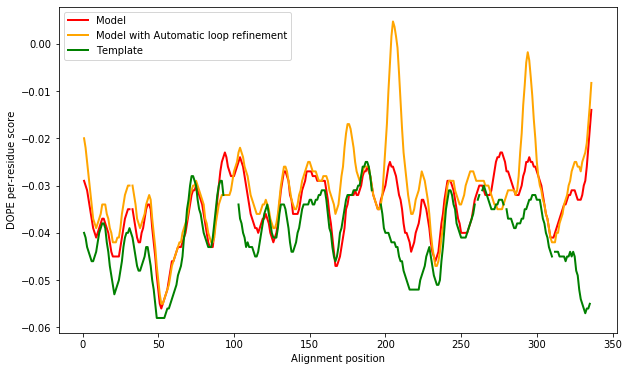

In [145]:
e = modeller.environ()
a = modeller.alignment(e, file='TvLDH-1bdmA.ali')

template = get_profile('1bdmA.profile', a['1bdmA'])
model = get_profile('TvLDH.profile', a['TvLDH'])
model_loop = get_profile('TvLDH_loop.profile', a['TvLDH'])


# Plot the template and model profiles in the same plot for comparison:
pylab.figure(1, figsize=(10,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(model_loop, color='orange', linewidth=2, label='Model with Automatic loop refinement')
pylab.plot(template, color='green', linewidth=2, label='Template')
pylab.legend()
#pylab.savefig('dope_profile.png', dpi=65)

## dope_loopmodel

In [159]:
a = dope_loopmodel(env,
              alnfile  = 'TvLDH-1bdmA.ali',     # alignment filename
              knowns   = '1bdmA',          # codes of the templates
              sequence = 'TvLDH')              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.md_level = None                   # No refinement of model

a.loop.starting_model = 1           # First loop model
a.loop.ending_model   = 4           # Last loop model
a.loop.md_level       = refine.fast # Loop model refinement level

a.make() 

automodel__W> Topology and/or parameter libraries already in memory. These will
                be used instead of the automodel defaults. If this is not what you
                want, clear them before creating the automodel object with
                env.libs.topology.clear() and env.libs.parameters.clear()
openf___224_> Open           TvLDH-1bdmA.ali

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:     74208348   72469.094    70.771

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:     74209798   72470.508    70.772

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:     74212698   72473.336    70.775

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:     74218498   72479.000    70.780

Dynamically allocated memory at   amaxalignment [B,KiB,MiB]:     74335554   72593.312    70.892

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:     74336822   72594.555    70.893

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:

openf___224_> Open           TvLDH.BL00040001.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:     85145053   83149.469    81.201

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:     85145129   83149.539    81.201

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:     85145300   83149.703    81.201

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:     85146150   83150.539    81.202

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:     85147408   83151.766    81.203

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:     85149312   83153.625    81.205

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:     85149352   83153.664    81.205

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:     85149442   83153.750    81.205

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:     85152298   83156.539    81.208

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:     85152358   

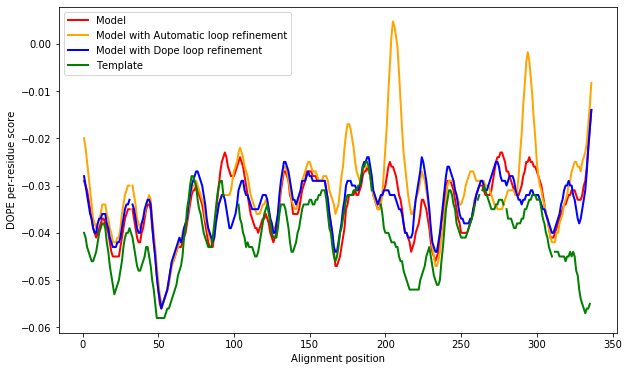

In [162]:
# read model file
mdl = complete_pdb(env, 'TvLDH.BL00040001.pdb')

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='TvLDH_dopeloop.profile',
              normalize_profile=True, smoothing_window=15)

e = modeller.environ()
a = modeller.alignment(e, file='TvLDH-1bdmA.ali')

template = get_profile('1bdmA.profile', a['1bdmA'])
model = get_profile('TvLDH.profile', a['TvLDH'])
model_loop = get_profile('TvLDH_loop.profile', a['TvLDH'])
model_dopeloop = get_profile('TvLDH_dopeloop.profile', a['TvLDH'])


# Plot the template and model profiles in the same plot for comparison:
pylab.figure(1, figsize=(10,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(model_loop, color='orange', linewidth=2, label='Model with Automatic loop refinement')
pylab.plot(model_dopeloop, color='blue', linewidth=2, label='Model with Dope loop refinement')
pylab.plot(template, color='green', linewidth=2, label='Template')
pylab.legend()
#pylab.savefig('dope_profile.png', dpi=65)